In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from default_func import extract_image_file_name_from_lidar_file_name, extract_bboxes_file_name_from_image_file_name

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from os.path import join
import glob

root_path_train = '.\\camera_lidar_semantic_bboxes\\train\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_train, '*\\lidar\\cam_front_center\\*.npz')))

root_path_test = '.\\camera_lidar_semantic_bboxes\\test\\'
# get the list of files in lidar directory
file_names_lidar_test = sorted(glob.glob(join(root_path_test, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_train = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_train, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_train.append(file_name_image)

file_names_photo_test = []

for file_name_lidar in file_names_lidar_test:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_test, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_test.append(file_name_image)

file_names_bboxes_train = []

for file_name_image, file_name_lidar in zip(file_names_photo_train, file_names_lidar_train):
    seq_name = file_name_lidar.split('\\')[3]
    file_name_bboxes = extract_bboxes_file_name_from_image_file_name(file_name_image)
    file_name_bboxes = join(root_path_train, seq_name, 'label3D\\cam_front_center\\', file_name_bboxes)
    file_names_bboxes_train.append(file_name_bboxes)

file_names_bboxes_test = []

for file_name_image, file_name_lidar in zip(file_names_photo_test, file_names_lidar_test):
    seq_name = file_name_lidar.split('\\')[3]
    file_name_bboxes = extract_bboxes_file_name_from_image_file_name(file_name_image)
    file_name_bboxes = join(root_path_test, seq_name, 'label3D\\cam_front_center\\', file_name_bboxes)
    file_names_bboxes_test.append(file_name_bboxes)

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from default_func import read_bounding_boxes_2d

def resize_bboxes(bboxes, original_size, target_size):
    """
    Масштабирует bounding box'ы при изменении размера изображения.
    
    Args:
        bboxes (torch.Tensor): Тензор размером [N, 4] с координатами [left, top, right, bottom]
        original_size (tuple): Исходный размер изображения (width, height)
        target_size (tuple): Целевой размер изображения (width, height)
    
    Returns:
        torch.Tensor: Масштабированные bounding box'ы размером [N, 4]
    """
    orig_w, orig_h = original_size  # <- ИЗМЕНИЛОСЬ: (width, height)
    target_w, target_h = target_size  # <- ИЗМЕНИЛОСЬ: (width, height)
    
    # Вычисляем коэффициенты масштабирования
    scale_x = target_w / orig_w
    scale_y = target_h / orig_h
    
    # Создаем копию тензора для избежания изменения оригинальных данных
    scaled_bboxes = bboxes.clone().float()
    
    # Масштабируем координаты
    scaled_bboxes[:, 0] *= scale_x  # left
    scaled_bboxes[:, 1] *= scale_y  # top
    scaled_bboxes[:, 2] *= scale_x  # right
    scaled_bboxes[:, 3] *= scale_y  # bottom
    
    return scaled_bboxes

class DetectionDataset(Dataset):
    def __init__(self, image_files, bbox_files, image_size=(300, 300), output_format="SSD"):
        self.image_files = image_files
        self.bbox_files = bbox_files
        self.image_size = image_size  # (height, width)
        self.output_format = output_format

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Загружаем картинку
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        original_size = img.size  # (width, height)
        
        # Загружаем боксы
        target = read_bounding_boxes_2d(self.bbox_files[idx], original_size, output_format=self.output_format)
        
        # Сохраняем оригинальный размер для дебаггинга
        target['original_size'] = torch.tensor(original_size)
        
        # Преобразуем картинку
        img_transformed = self.transform(img)
        transformed_size = (img_transformed.shape[2], img_transformed.shape[1])  # (width, height)
        
        # Масштабируем боксы
        target['boxes'] = resize_bboxes(target['boxes'], original_size, transformed_size).to(device)
        #target['boxes'] = target['boxes'].to(device)
        target['labels'] = target['labels'].to(device)
        
        return img_transformed, target


# collate_fn для DataLoader
def collate_fn(batch):
    images = [item[0] for item in batch]   # список тензоров картинок
    images = torch.stack(images, dim=0).to(device)
    targets = [item[1] for item in batch]  # список словарей с боксами
    return images, targets


# Пример использования
train_dataset = DetectionDataset(file_names_photo_train, file_names_bboxes_train, image_size=(300, 300))
test_dataset  = DetectionDataset(file_names_photo_test, file_names_bboxes_test, image_size=(300, 300))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [7]:
import torchvision.ops as ops
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F

def apply_nms(predictions, iou_threshold=0.5, score_threshold=0.5):
    """
    Применяет Non-Maximum Suppression (NMS) к предсказаниям SSD.

    predictions: словарь с ключами 'boxes', 'labels', 'scores'
    iou_threshold: порог IoU для удаления дубликатов
    score_threshold: минимальная уверенность, с которой бокс считается валидным
    """
    result = []
    for predict in predictions:
        boxes = predict['boxes']
        scores = predict['scores']
        labels = predict['labels']

        # Оставляем только боксы с высокой уверенностью
        keep = scores > score_threshold
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        # Применяем NMS
        keep_indices = ops.nms(boxes, scores, iou_threshold)

        result.append({
            'boxes': boxes[keep_indices],
            'labels': labels[keep_indices],
            'scores': scores[keep_indices]
        })

    return result

def visualize_batch_ssd(images, targets, class_names=None):
    batch_size = images.shape[0]  # Количество изображений в батче
    
    for i in range(batch_size):
        img = images[i].cpu()  # Переводим на CPU
        img = (img * 255).byte()  # Преобразуем в [0, 255]
        
        target = targets[i]
        boxes = target['boxes'].cpu().int()  # Достаем координаты боксов
        labels = target['labels'].cpu().tolist()  # Достаем метки классов
        scores = target['scores'].cpu().tolist()  # Достаем вероятности
        
        # Генерируем текстовые метки с учетом имен классов
        if class_names:
            labels = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels, scores)]
        else:
            labels = [f"{label}: {score:.2f}" for label, score in zip(labels, scores)]
        
        img = draw_bounding_boxes(img, boxes, labels=labels, colors="red", width=2)
        
        plt.figure(figsize=(6, 6))
        img = F.to_pil_image(img)
        plt.imshow(img)
        plt.axis("off")
        plt.show()

def visualize_batch_ssd_with_GT(images, targets, ground_truth, class_names=None, img_name = 'test_image', save = False):
    batch_size = images.shape[0]  # Количество изображений в батче
    
    
    # ImageNet стандартные параметры нормализации
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
    IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])
    
    batch_size = images.shape[0]
    
    for i in range(batch_size):
        # Денормализуем ImageNet
        img = images[i].cpu().clone()
        
        # Денормализация: image = (image * std) + mean
        for c in range(3):
            img[c] = img[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
        
        # Обрезаем значения в диапазон [0, 1]
        img = torch.clamp(img, 0, 1)
        
        # Преобразуем в [0, 255] для визуализации
        img = (img * 255).byte()
        
        target = targets[i]
        boxes = target['boxes'].cpu().int()  # Достаем координаты боксов
        labels = target['labels'].cpu().tolist()  # Достаем метки классов
        scores = target['scores'].cpu().tolist()  # Достаем вероятности

        gt = ground_truth[i]
        boxes_gt = gt['boxes'].cpu().int()  # Достаем координаты боксов
        labels_gt = gt['labels'].cpu().tolist()  # Достаем метки классов
        scores_gt = gt['scores'].cpu().tolist()  # Достаем вероятности
        
        # Генерируем текстовые метки с учетом имен классов
        if class_names:
            labels = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels, scores)]
        else:
            labels = [f"{label}: {score:.2f}" for label, score in zip(labels, scores)]

        if class_names:
            labels_gt = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels_gt, scores_gt)]
        else:
            labels_gt = [f"{label}: {score:.2f}" for label, score in zip(labels_gt, scores_gt)]

        img = draw_bounding_boxes(img, boxes_gt, labels=labels_gt, colors="green", width=2)
        img = draw_bounding_boxes(img, boxes, labels=labels, colors="red", width=2)
        
        plt.figure(figsize=(6, 6))
        img = F.to_pil_image(img)
        plt.imshow(img)
        plt.axis("off")
        if save: 
            plt.savefig(f'{img_name}_{i}.png')
        else:
            plt.show()

In [8]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Загружаем модель с предобученными весами (COCO)
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Получаем число входных признаков для классификатора
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Определяем нужное число классов (например, 8 классов + фон)
num_classes = 6 + 1

# Заменяем классификатор на новый, соответствующий числу классов
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [9]:
import torch.optim.lr_scheduler as lr_scheduler

#device = 'cpu'

model = model.to(device)

# Оптимизатор
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

# Планировщик (каждые 10 эпох уменьшает lr в 2 раза)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

In [12]:
num_epochs = 40
history = []
history_test = []

In [13]:
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_test_loss = 0

    # Прогресс-бар для обучающего цикла
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False):
        try:
            optimizer.zero_grad()
            loss_dict = model(images, targets)  # Обучение модели (SSD/Faster R-CNN выдаёт лоссы)
            loss = sum(loss for loss in loss_dict.values())

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        except:
            print('Box zeros')

    avg_train_loss = total_loss / len(train_loader)
    history.append(avg_train_loss)
    #history.append(total_loss)

    # Прогресс-бар для тестового цикла
    for images_test, targets_test in tqdm(test_loader, desc=f"Epoch {epoch+1} Test", leave=False):
        try:
            loss_dict = model(images_test, targets_test)  # Тест модели
            loss = sum(loss for loss in loss_dict.values())
            total_test_loss += loss.item()
        except:
            print('Box zeros')

    avg_test_loss = total_test_loss / len(test_loader)
    history_test.append(avg_test_loss)
    #history_test.append(total_test_loss)

    # Обновляем learning rate на основе test loss
    # scheduler.step(avg_test_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

Epoch 1 Train:  35%|███▌      | 1082/3059 [11:30<16:10,  2.04it/s]

Box zeros


Epoch 1 Train:  72%|███████▏  | 2197/3059 [22:01<06:39,  2.16it/s]

Box zeros


Epoch 1, Train Loss: 0.3313, Test Loss: 0.1484


Epoch 2 Train:  32%|███▏      | 987/3059 [09:02<16:15,  2.12it/s]

Box zeros


Epoch 2 Train:  95%|█████████▌| 2916/3059 [27:05<01:11,  2.01it/s]

Box zeros


Epoch 2, Train Loss: 0.2760, Test Loss: 0.1422


Epoch 3 Train:  50%|████▉     | 1524/3059 [14:00<12:16,  2.09it/s]

Box zeros


Epoch 3 Train:  61%|██████▏   | 1879/3059 [17:23<09:24,  2.09it/s]

Box zeros


Epoch 3, Train Loss: 0.2499, Test Loss: 0.1420


Epoch 4 Train:  51%|█████     | 1563/3059 [14:31<11:57,  2.08it/s]

Box zeros


Epoch 4 Train:  80%|████████  | 2451/3059 [22:45<05:01,  2.01it/s]

Box zeros


Epoch 4, Train Loss: 0.2300, Test Loss: 0.1437


Epoch 5 Train:  19%|█▉        | 576/3059 [05:13<22:01,  1.88it/s]

Box zeros


KeyboardInterrupt: 

In [17]:
checkpoint = {
    'epoch': epoch,  # количество выполненных эпох
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': total_loss,  # значение функции потерь
    # можно добавлять и другие метрики, нужные для ваших экспериментов
}
torch.save(checkpoint, '.\\models\\pitstop_Faster_R_CNN.pth')

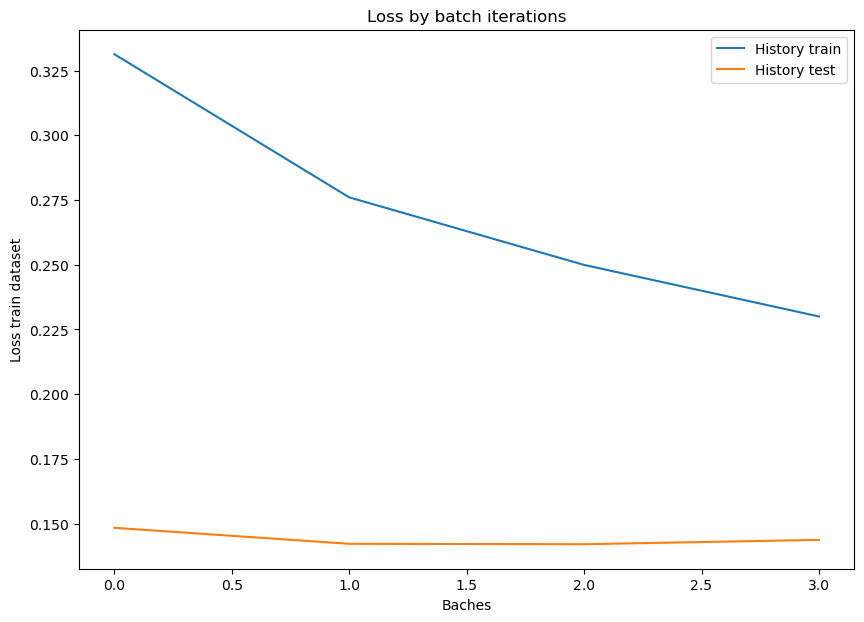

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(history, label = 'History train')
plt.plot(history_test, label = 'History test')
plt.title('Loss by batch iterations')
plt.ylabel('Loss train dataset')
plt.xlabel('Baches')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()

plt.show()

In [10]:
checkpoint = torch.load('.\\models\\pitstop_Faster_R_CNN.pth', map_location=device)
    
# Загружаем состояние модели
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

  0%|          | 0/66 [00:00<?, ?it/s]


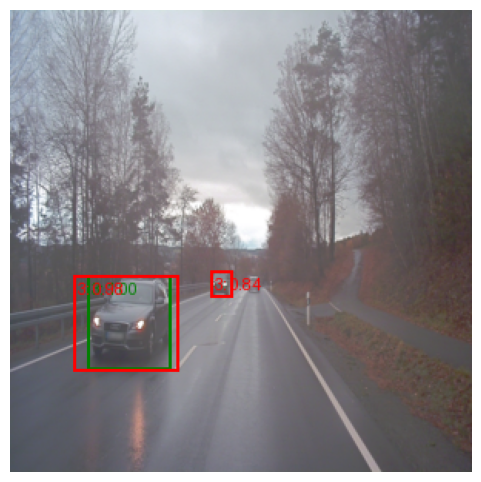

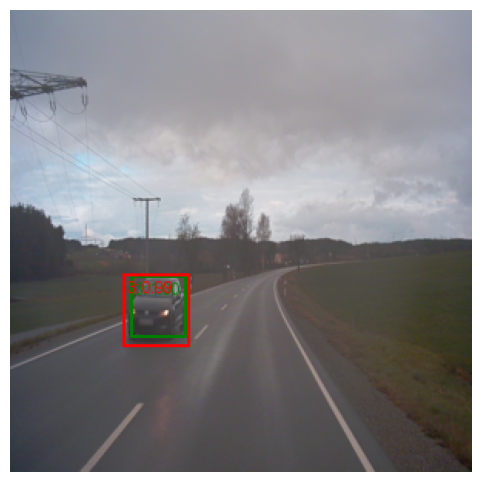

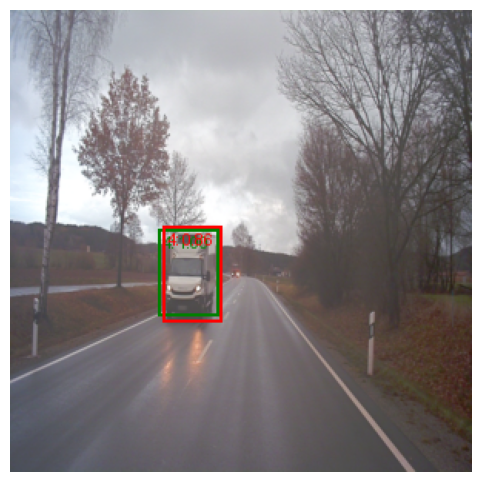

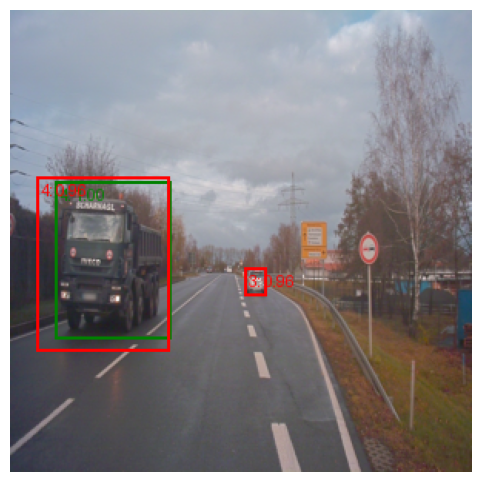

In [22]:
from tqdm import tqdm

# Визуализация на тест сете
model.eval()
num = 0

for images_test, targets_test in tqdm(test_loader):
    #image = test_images[0].to(device)
    predictions = model(images_test)
    for target in targets_test:
        n = len(target['labels'])
        target['scores'] = torch.ones(n, dtype=torch.float32)
    filtered_preds = apply_nms(predictions)
    visualize_batch_ssd_with_GT(images_test, filtered_preds, targets_test, img_name= f'.\\tests\\Faster_R_CNN\\test_image_bach_{num}', save= True)
    num +=1
    
    break


In [ ]:
from PIL import Image
import os
import glob

def create_optimized_gif(input_folder, output_path, resize_factor=0.5, delay=80):
    # Получаем все изображения из папки
    images = []
    for file_path in sorted(glob.glob(os.path.join(input_folder, '*.*'))):
        try:
            with Image.open(file_path) as img:
                # Сжатие изображения
                if resize_factor < 1:
                    new_size = (int(img.width * resize_factor), int(img.height * resize_factor))
                    img = img.resize(new_size, Image.Resampling.LANCZOS)
                
                # Конвертация в RGB (если нужно)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                images.append(img.copy())
        except Exception as e:
            print(f"Ошибка при обработке {file_path}: {e}")
    
    # Сохранение как оптимизированный GIF
    if images:
        images[0].save(
            output_path,
            save_all=True,
            append_images=images[1:],
            optimize=True,
            duration=delay,
            loop=0,
            disposal=2
        )
        print(f"GIF создан: {output_path}")

# Использование
create_optimized_gif('.\\tests\\Faster_R_CNN', '.\\results_2d_detection\\output.gif', resize_factor=1)

GIF создан: .\tests\output.gif


DETR: 4 files found
SSD_classic: 4 files found
SSD_rn34: 4 files found
SSD_rn50: 4 files found
SSD_resnet50fpn: 4 files found
faster_r_cnn: 4 files found
Creating grid: 4 rows x 6 columns


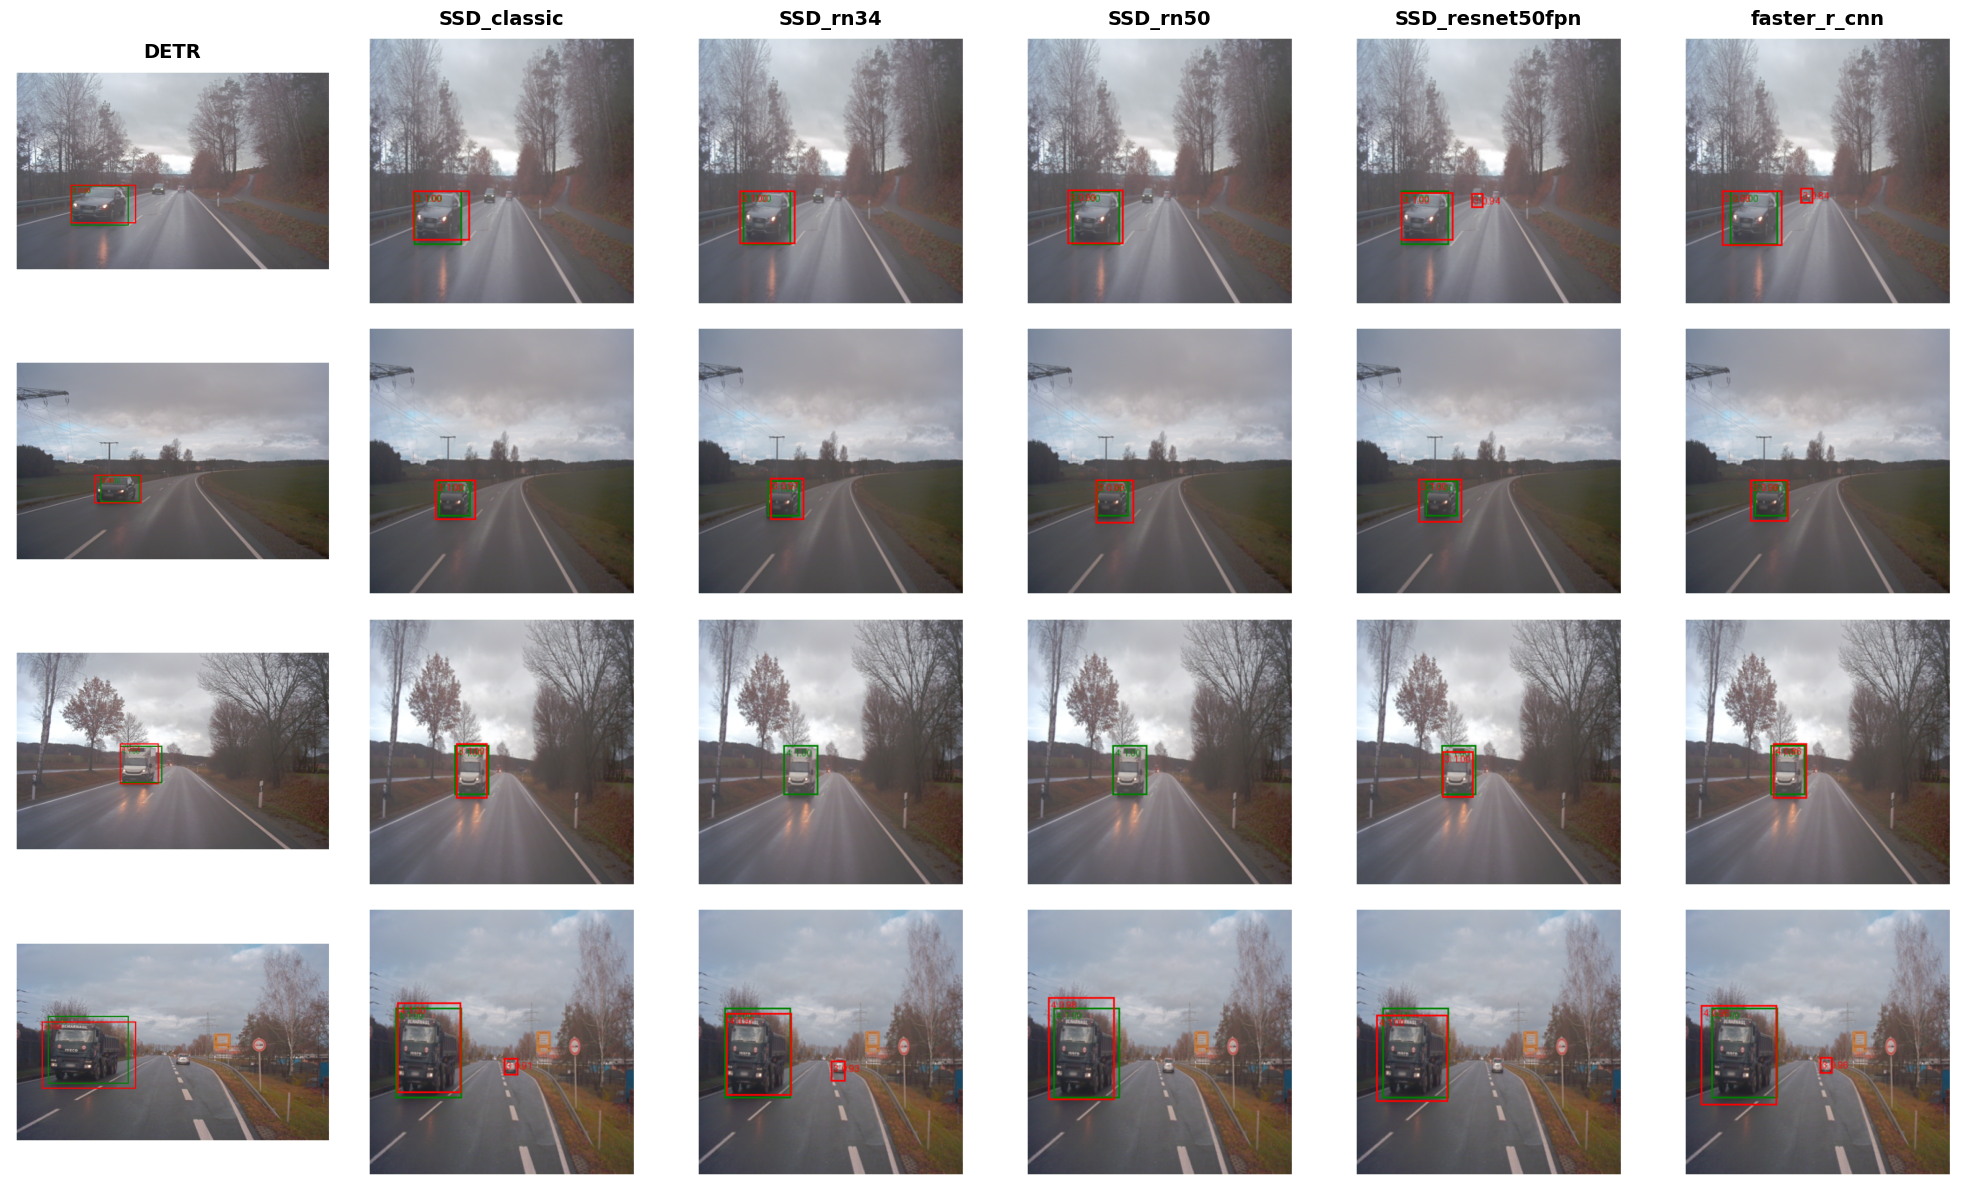

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from glob import glob
import re

# Путь к папке с изображениями
folder_path = '.\\results_2d_detection\\'

# Список алгоритмов
names = ['DETR', 'SSD_classic', 'SSD_rn34', 'SSD_rn50', 'SSD_resnet50fpn', 'faster_r_cnn']

# Найдем все файлы для каждого алгоритма
algorithm_files = {}
for name in names:
    pattern = os.path.join(folder_path, f"{name}*.png")
    files = glob(pattern)
    
    # Более надежный способ извлечения чисел из имен файлов
    def extract_number(filename):
        # Ищем любые цифры в имени файла после названия алгоритма
        match = re.search(r'\d+', filename.split(name)[-1])
        return int(match.group()) if match else 0
    
    files.sort(key=extract_number)
    algorithm_files[name] = files
    print(f"{name}: {len(files)} files found")

# Определим количество строк (по максимальному количеству файлов у алгоритма)
num_rows = max(len(files) for files in algorithm_files.values())
num_cols = len(names)

print(f"Creating grid: {num_rows} rows x {num_cols} columns")

# Создаем фигуру и оси
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 3*num_rows))

# Обрабатываем разные случаи размерности axes
if num_rows == 1 and num_cols == 1:
    axes = [[axes]]
elif num_rows == 1:
    axes = axes.reshape(1, -1)
elif num_cols == 1:
    axes = axes.reshape(-1, 1)

# Заполняем сетку изображениями
for col_idx, name in enumerate(names):
    files = algorithm_files[name]
    
    for row_idx in range(num_rows):
        ax = axes[row_idx, col_idx]
        
        if row_idx < len(files):
            try:
                # Загружаем и отображаем изображение
                img = mpimg.imread(files[row_idx])
                ax.imshow(img)
                ax.axis('off')
                
                # Добавляем заголовки для первого столбца и первой строки
                if col_idx == 0:
                    ax.set_ylabel(f'Image {row_idx + 1}', fontsize=12, rotation=0, ha='right', va='center')
                if row_idx == 0:
                    ax.set_title(name, fontsize=14, fontweight='bold')
            except Exception as e:
                print(f"Error loading {files[row_idx]}: {e}")
                ax.axis('off')
                ax.text(0.5, 0.5, 'Error', ha='center', va='center')
        else:
            # Пустая ячейка, если файла нет
            ax.axis('off')

plt.tight_layout()
plt.show()

In [12]:
from tqdm import tqdm

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images_test, targets_test in tqdm(test_loader):
        preds = model(images_test)
        preds = apply_nms(preds)  # твоя фильтрация NMS

        # preds уже список словарей: [{'boxes':..., 'labels':..., 'scores':...}, ...]
        # targets_test — список словарей: [{'boxes':..., 'labels':...}, ...]

        all_preds.extend(preds)
        all_targets.extend(targets_test)

100%|██████████| 66/66 [00:25<00:00,  2.59it/s]


In [13]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision(iou_type="bbox")
metric.update(all_preds, all_targets)
results = metric.compute()
print(results)

{'map': tensor(0.3768), 'map_50': tensor(0.6494), 'map_75': tensor(0.4444), 'map_small': tensor(0.3141), 'map_medium': tensor(0.4758), 'map_large': tensor(0.1710), 'mar_1': tensor(0.3963), 'mar_10': tensor(0.4518), 'mar_100': tensor(0.4518), 'mar_small': tensor(0.4154), 'mar_medium': tensor(0.5440), 'mar_large': tensor(0.2037), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([3, 4, 6], dtype=torch.int32)}


In [17]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from torchvision.ops import box_iou

def collect_class_scores(all_preds, all_targets, class_id, iou_threshold=0.5):
    y_true = []
    y_scores = []

    for pred, target in zip(all_preds, all_targets):
        ious = box_iou(pred['boxes'], target['boxes']) if len(target['boxes']) > 0 else None

        for i, (box, label, score) in enumerate(zip(pred['boxes'], pred['labels'], pred['scores'])):
            if label.item() != class_id:
                continue

            # если GT есть
            if ious is not None and len(target['labels']) > 0:
                iou_vals, gt_idx = ious[i].max(dim=0)
                match = (iou_vals >= iou_threshold) and (target['labels'][gt_idx] == class_id)
                y_true.append(int(match))
            else:
                y_true.append(0)

            y_scores.append(score.item())

    return np.array(y_true), np.array(y_scores)

def plot_pr_curve(all_preds, all_targets, class_id, iou_threshold=0.5):
    y_true, y_scores = collect_class_scores(all_preds, all_targets, class_id, iou_threshold)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.plot(recall, precision, label=f"Class {class_id}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve")
    plt.legend()
    plt.grid()
    plt.show()


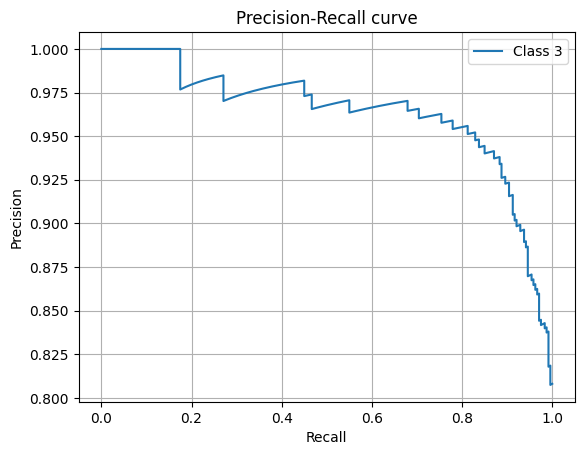

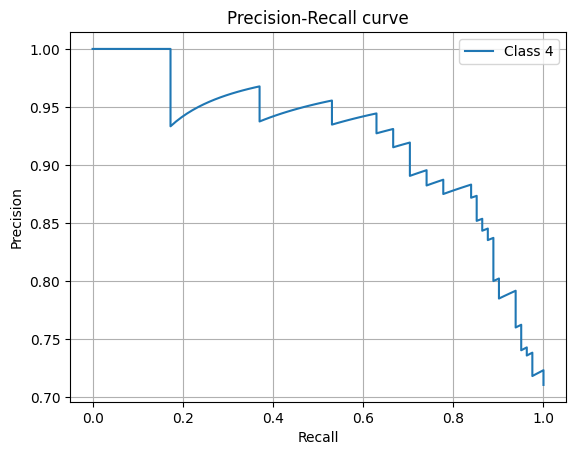

In [20]:
plot_pr_curve(all_preds, all_targets, class_id=3, iou_threshold=0.5)
plot_pr_curve(all_preds, all_targets, class_id=4, iou_threshold=0.5)

In [40]:
import torch
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt


def box_iou(boxes1, boxes2):
    area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0)
    area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  

    wh = (rb - lt).clamp(min=0)  
    inter = wh[..., 0] * wh[..., 1]  

    union = area1[:, None] + area2 - inter
    return inter / union.clamp(min=1e-6)


def collect_class_detections(all_preds, all_targets, class_id, iou_threshold=0.5):
    y_true, y_scores = [], []

    for pred, target in zip(all_preds, all_targets):
        preds_cls = pred['labels'] == class_id
        boxes_pred = pred['boxes'][preds_cls]
        scores_pred = pred['scores'][preds_cls]

        gts_cls = target['labels'] == class_id
        boxes_gt = target['boxes'][gts_cls]

        matched_gt = set()
        for box, score in zip(boxes_pred, scores_pred):
            if len(boxes_gt) > 0:
                ious = box_iou(box.unsqueeze(0), boxes_gt).squeeze(0)
                best_iou, idx = ious.max(0)
                if best_iou >= iou_threshold and idx.item() not in matched_gt:
                    y_true.append(1)
                    matched_gt.add(idx.item())
                else:
                    y_true.append(0)
            else:
                y_true.append(0)

            y_scores.append(score.item())

        # FN для оставшихся GT
        for _ in range(len(boxes_gt) - len(matched_gt)):
            y_true.append(1)
            y_scores.append(0.0)

    return np.array(y_true), np.array(y_scores)



def evaluate_map(all_preds, all_targets, class_ids, iou_threshold=0.5, plot_classes=None):
    aps = {}
    pr_curves = {}  # тут будем хранить кривые: {class_id: (precision, recall)}

    for cid in class_ids:
        y_true, y_scores = collect_class_detections(all_preds, all_targets, cid, iou_threshold)

        if len(np.unique(y_true)) < 2:
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = auc(recall, precision)
        aps[cid] = ap
        pr_curves[cid] = (precision, recall)

        if plot_classes and cid in plot_classes:
            plt.plot(recall, precision, label=f"Class {cid} (AP={ap:.3f})")

    if plot_classes:
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall curves")
        plt.legend()
        plt.grid()
        plt.show()

    mAP = np.mean(list(aps.values())) if aps else 0.0
    return mAP, aps, pr_curves


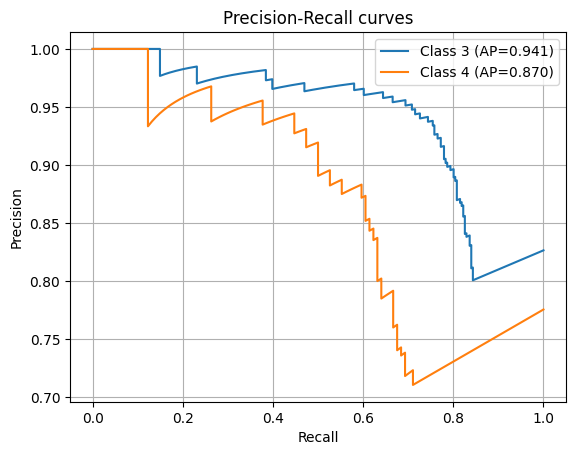

mAP: 0.9055462107455889
APs по классам: {3: 0.9413297503523583, 4: 0.8697626711388194}


In [41]:
# После инференса (как у тебя в коде):
# all_preds, all_targets собраны

class_ids = [3, 4]   # интересующие классы
mAP, aps, pr = evaluate_map(all_preds, all_targets, class_ids, iou_threshold=0.5, plot_classes=[3, 4])

print("mAP:", mAP)
print("APs по классам:", aps)

In [43]:
np.savez(".\\results_2d_detection\\pr_curves\\pr_curves_faster_r_cnn.npz", **{str(k): v for k,v in pr.items()})

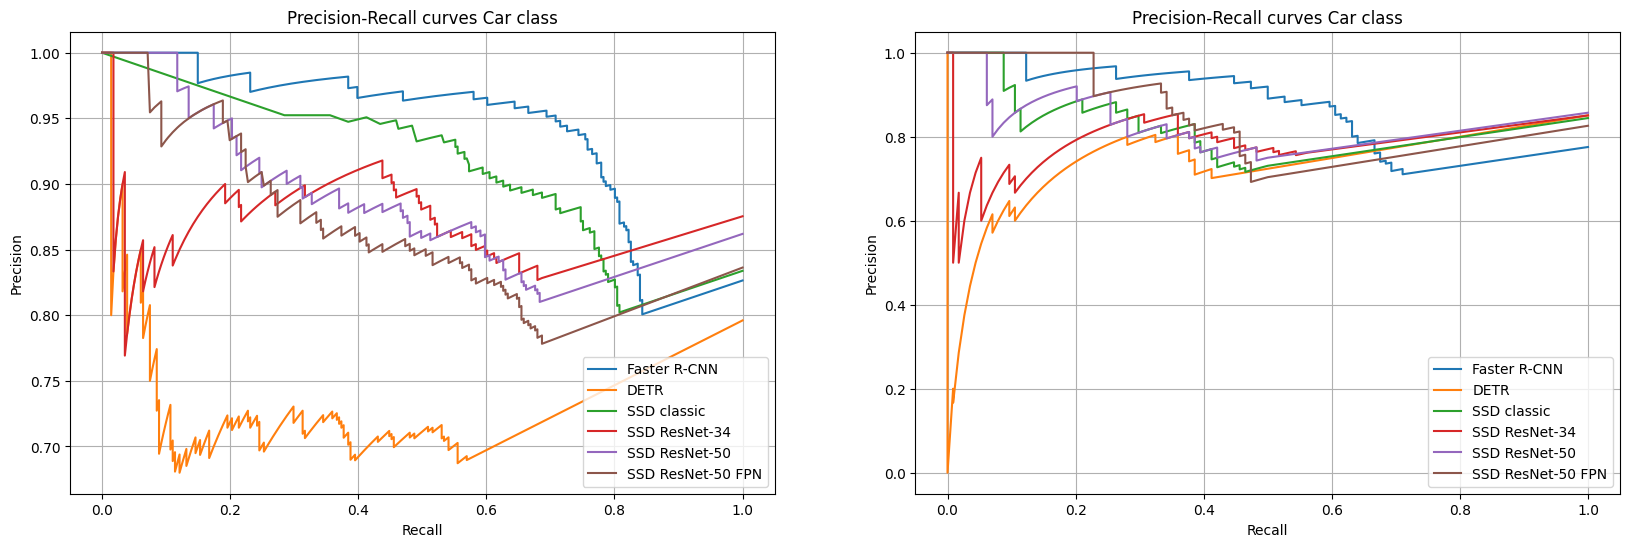

In [51]:
data_faster_r_cnn = np.load(".\\results_2d_detection\\pr_curves\\pr_curves_faster_r_cnn.npz", allow_pickle=True)
precision_faster_r_cnn_3, recall_faster_r_cnn_3 = data_faster_r_cnn["3"]  # для класса 0
precision_faster_r_cnn_4, recall_faster_r_cnn_4 = data_faster_r_cnn["4"]  # для класса 0

data_DETR = np.load(".\\results_2d_detection\\pr_curves\\pr_curves_DETR.npz", allow_pickle=True)
precision_DETR_3, recall_DETR_3 = data_DETR["3"]  # для класса 0
precision_DETR_4, recall_DETR_4 = data_DETR["4"]  # для класса 0

data_ssd_classic = np.load(".\\results_2d_detection\\pr_curves\\pr_curves_ssd_classic.npz", allow_pickle=True)
precision_ssd_classic_3, recall_ssd_classic_3 = data_ssd_classic["3"]  # для класса 0
precision_ssd_classic_4, recall_ssd_classic_4 = data_ssd_classic["4"]  # для класса 0

data_ssd_rn34 = np.load(".\\results_2d_detection\\pr_curves\\pr_curves_ssd_rn34.npz", allow_pickle=True)
precision_ssd_rn34_3, recall_ssd_rn34_3 = data_ssd_rn34["3"]  # для класса 0
precision_ssd_rn34_4, recall_ssd_rn34_4 = data_ssd_rn34["4"]  # для класса 0

data_ssd_rn50 = np.load(".\\results_2d_detection\\pr_curves\\pr_curves_ssd_rn50.npz", allow_pickle=True)
precision_ssd_rn50_3, recall_ssd_rn50_3 = data_ssd_rn50["3"]  # для класса 0
precision_ssd_rn50_4, recall_ssd_rn50_4 = data_ssd_rn50["4"]  # для класса 0

data_ssd_rn50_fcp = np.load(".\\results_2d_detection\\pr_curves\\pr_curves_ssd_rn50_fpn.npz", allow_pickle=True)
precision_ssd_rn50_fcp_3, recall_ssd_rn50_fcp_3 = data_ssd_rn50_fcp["3"]  # для класса 0
precision_ssd_rn50_fcp_4, recall_ssd_rn50_fcp_4 = data_ssd_rn50_fcp["4"]  # для класса 0

# Создаем фигуру и оси
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.plot(recall_faster_r_cnn_3, precision_faster_r_cnn_3, label = 'Faster R-CNN')
ax1.plot(recall_DETR_3, precision_DETR_3, label = 'DETR')
ax1.plot(recall_ssd_classic_3, precision_ssd_classic_3, label = 'SSD classic')
ax1.plot(recall_ssd_rn34_3, precision_ssd_rn34_3, label = 'SSD ResNet-34')
ax1.plot(recall_ssd_rn50_3, precision_ssd_rn50_3, label = 'SSD ResNet-50')
ax1.plot(recall_ssd_rn50_fcp_3, precision_ssd_rn50_fcp_3, label = 'SSD ResNet-50 FPN')
ax1.set_title("Precision-Recall curves Car class")
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend()
ax1.grid()


ax2.plot(recall_faster_r_cnn_4, precision_faster_r_cnn_4, label = 'Faster R-CNN')
ax2.plot(recall_DETR_4, precision_DETR_4, label = 'DETR')
ax2.plot(recall_ssd_classic_4, precision_ssd_classic_4, label = 'SSD classic')
ax2.plot(recall_ssd_rn34_4, precision_ssd_rn34_4, label = 'SSD ResNet-34')
ax2.plot(recall_ssd_rn50_4, precision_ssd_rn50_4, label = 'SSD ResNet-50')
ax2.plot(recall_ssd_rn50_fcp_4, precision_ssd_rn50_fcp_4, label = 'SSD ResNet-50 FPN')
ax2.set_title("Precision-Recall curves Car class")
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.grid()

plt.show()